In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filelist = 'Dados/P1000697s.jpg', 'Dados/P1000698s.jpg', 'Dados/P1000699s.jpg', 'Dados/P1000703s.jpg', 'Dados/P1000705s.jpg', 'Dados/P1000706s.jpg', 'Dados/P1000709s.jpg', 'Dados/P1000710s.jpg', 'Dados/P1000713s.jpg'
imgs = np.array([np.array(cv2.imread(fname)) for fname in filelist])

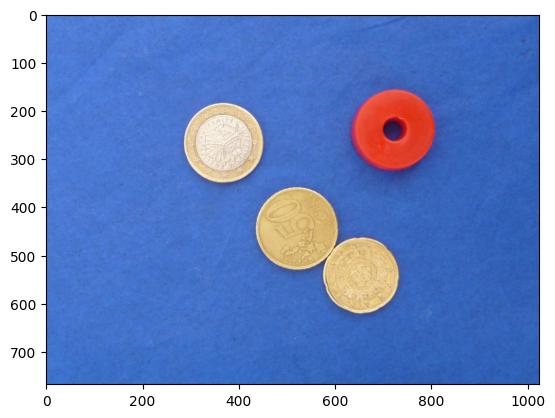

In [3]:
for i in range(len(imgs)):

    plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    #plt.figure()

In [4]:
def repartir_img(img):
    blue = img[:, :, 0]
    green = img[:, :, 1]
    red  = img[:, :,2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return blue, green, red, gray

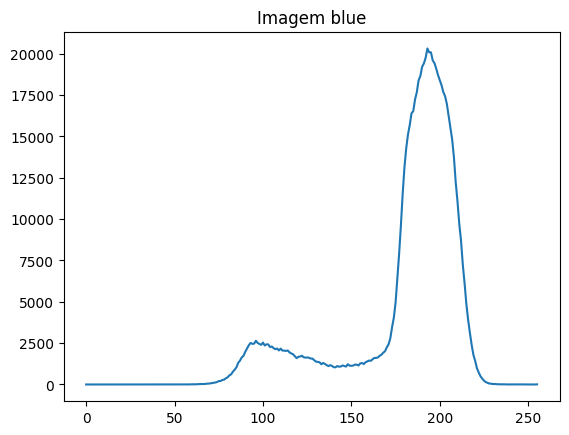

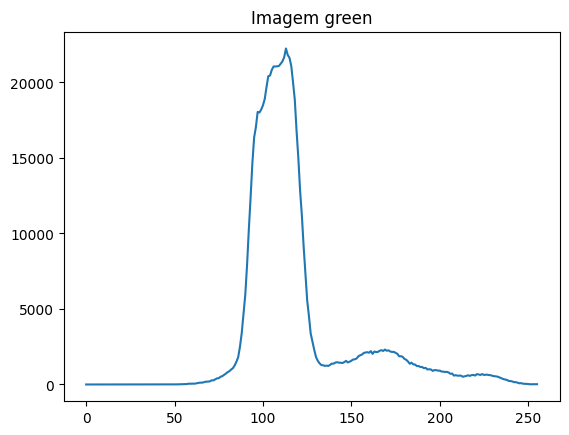

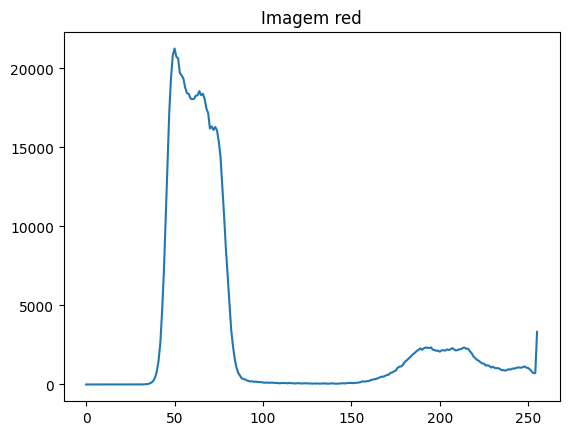

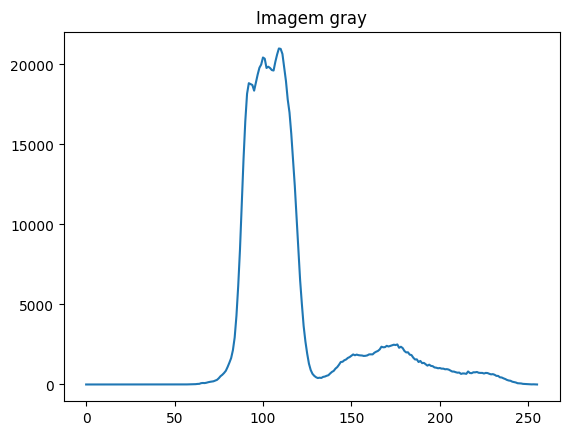

<Figure size 640x480 with 0 Axes>

In [5]:
blue, green, red, gray = repartir_img(imgs[0])
repartidas = [blue, green, red, gray]
nomes = ['blue', 'green', 'red', 'gray']
for i in range(len(repartidas)):
    hist = cv2.calcHist([repartidas[i]],[0],None,[256],[0,256])
    plt.title('Imagem ' + nomes[i])
    plt.plot(hist)
    plt.figure()

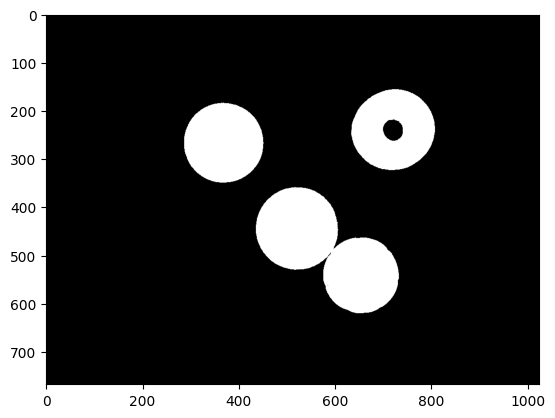

In [6]:
for i in range(len(imgs)):
    red = repartir_img(imgs[i])[2]
    __, binary_image = cv2.threshold(red, 0, 255, cv2.THRESH_OTSU)
    plt.imshow(binary_image,'gray',vmin=0,vmax=255)
    # plt.figure()
    

In [7]:
def img2Gblur(img):
    blur = cv2.blur(img, (8,8))
    return blur

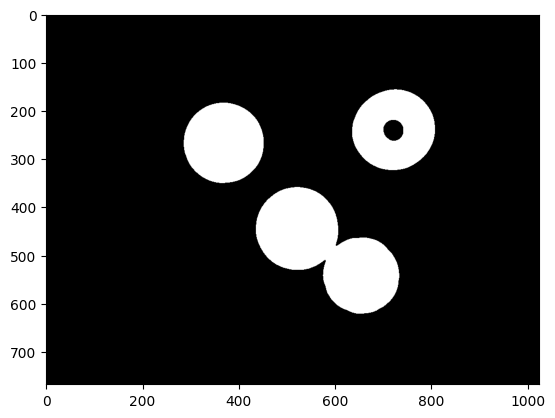

In [8]:
for i in range(len(imgs)):
    red = repartir_img(imgs[i])[2]
    blur = img2Gblur(red)
    __, binary_image = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)
    plt.imshow(binary_image,'gray')
    # plt.figure()

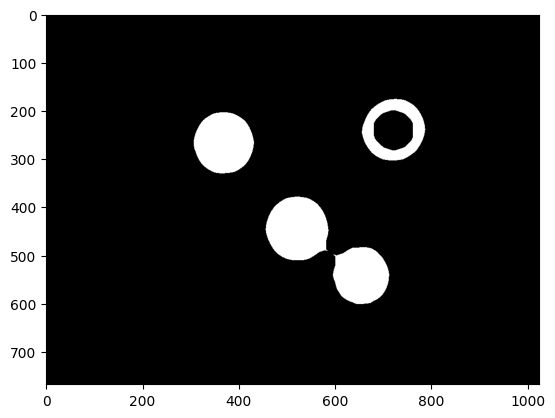

In [9]:
for i in range(len(imgs)):
    red = repartir_img(imgs[i])[2]
    blur = img2Gblur(red)
    __, binary_image = cv2.threshold(blur, 0, 255,  cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11), (-1,-1))
    binary_image = cv2.erode(binary_image, kernel, (-1,-1), iterations=4)  
    
    plt.imshow(binary_image,'gray')
    #plt.figure()

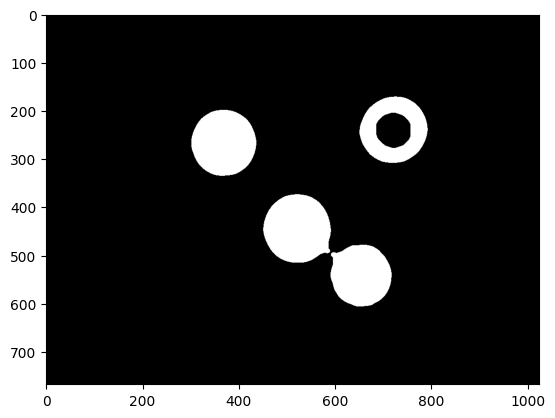

In [10]:
binary_imgs = []

for i in range(len(imgs)):
    red = repartir_img(imgs[i])[2]
    blur = img2Gblur(red)
    __, binary_image = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11), (-1,-1))
    binary_image = cv2.erode(binary_image, kernel, (-1,-1), iterations=4)

    binary_image = cv2.dilate(binary_image,kernel,iterations = 1)
    
    binary_imgs.append(binary_image.flatten())
    
    plt.imshow(binary_image,'gray')
    #plt.figure()


In [11]:
def classifica(area):
    c1  = 0
    c2  = 0
    c10 = 0
    c5  = 0
    c20 = 0
    c50 = 0
    e1  = 0
    e2  = 0
    if 5300 < area < 5700:
        c1+=1
    if 8000 < area < 8500:
        c2+=1
    if 9000 < area < 9700:
        c10+=1
    if 10400< area < 11200:
        c5+=1
    if 12000 < area < 13100:
        c20+=1
    if 13200 < area < 14400:
        e1+=1
    if 15500 < area < 16000:
        c50+=1
    est_2 = 15856 + np.mean((2460,863,1059,1244,960,1248))
    if est_2 < area:
        e2+=1
    
    return c1,c2,c10,c5,c20,c50,e1,e2

In [12]:
def quantifica(moedas):
    return moedas[0]*0.01 + moedas[1]*0.02 + moedas[2]*0.10 + moedas[3]*0.05 + moedas[4]*0.20 + moedas[5]*0.5 + moedas[6]*1.0 + moedas[7]*2.0

In [13]:
IMG_SHAPE = (768,1024)

VERDE = (82,255,99)
PRETO = (0,0,0)

CENT_RADIUS = 5
CENT_THICK  = -1
CENT_OFFSET = 20

BIG_TEXT_SCALE   = 0.8
SMALL_TEXT_SCLAE = 0.5

TEXT_THICK = 2

QUANT_ORG = (10,40)
VALOR_ORG = (10,70)

In [14]:
def calcula_raio(perimetro):
    raio = int(perimetro/(2*np.pi))
    return raio

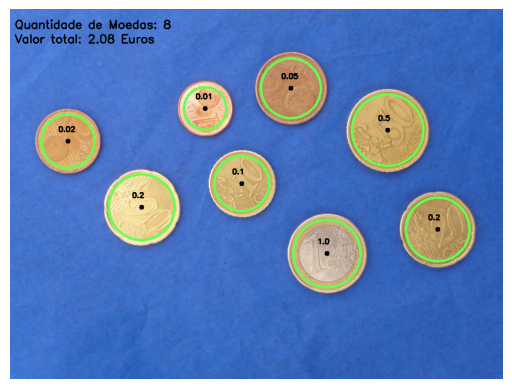

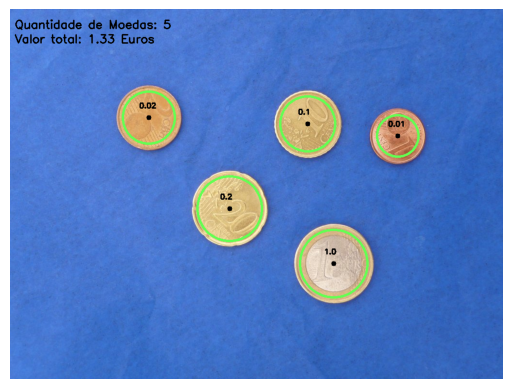

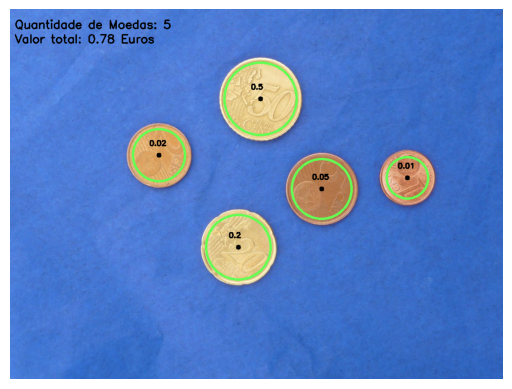

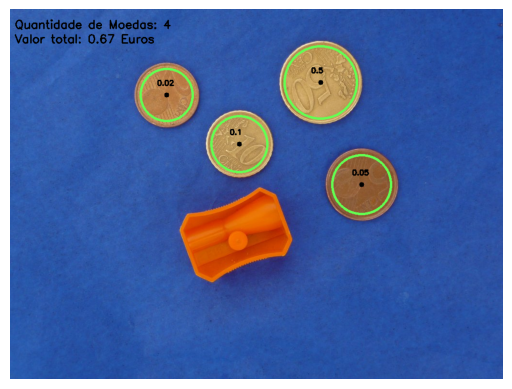

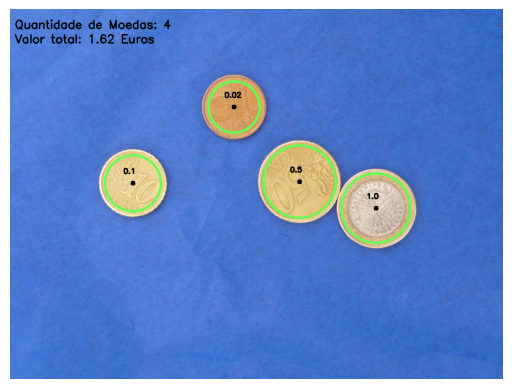

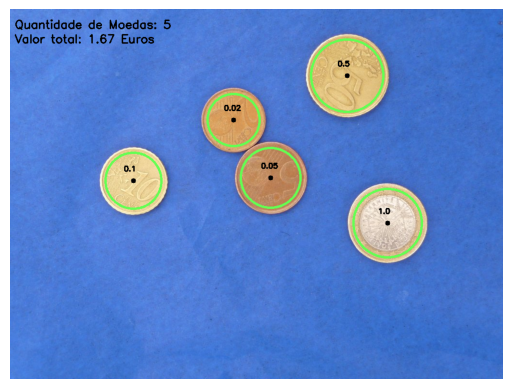

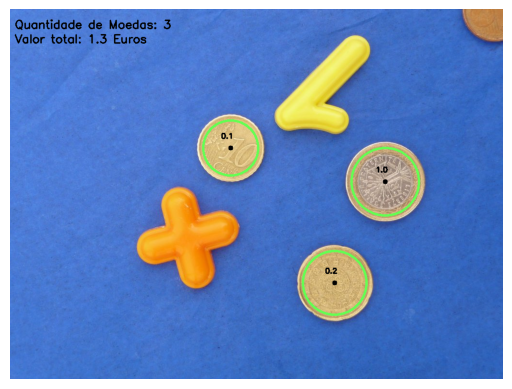

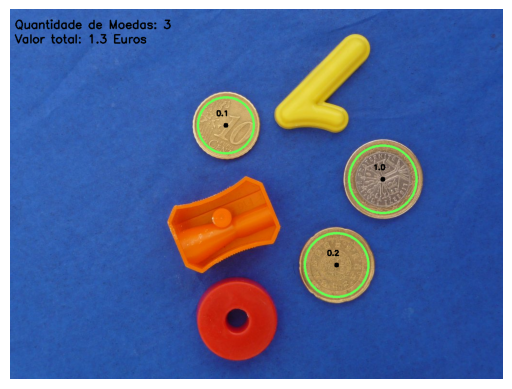

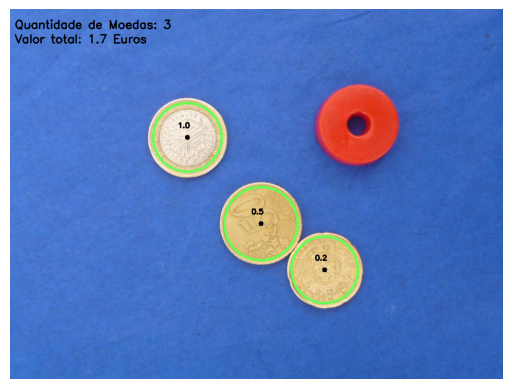

<Figure size 640x480 with 0 Axes>

In [15]:
num_moedas = 0
num_moedas_img = 0
valor = 0
soma  = 0
areas = []
pers = []

for i in range(len(imgs)):
    img_fixa = binary_imgs[i].reshape(IMG_SHAPE)
    cnts, h = cv2.findContours(img_fixa.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #print(h)
    #cv2.drawContours(imgs[i], cnts, -1, color=(0,255,0), thickness=2)
    for l in range(len(cnts)):
        area   = cv2.contourArea(cnts[l])           
        per    = cv2.arcLength(cnts[l], closed=True)
        circularidade = 4*np.pi*(area/(per**2))
        buraco = h[0][l][2] != -1 or h[0][l][3] != -1  
        
        #destinção dos circulos
        if not buraco and circularidade >=0.80:
            #calcula o centro da moeda
            M = cv2.moments(cnts[l])
            x = int(M['m10']/M['m00'])
            y = int(M['m01']/M['m00'])
            areas.append(area)
            pers.append(per)
            #classifica as moedas pela area das mesmas
            moeda = classifica(area)
            #conta o número de moedas
            num_moedas = num_moedas + 1
            num_moedas_img = num_moedas_img + 1
            #consoante o tamanho da moeda quantifica o tipo dela
            valor = quantifica(moeda)
            #soma os tipos para saber quantos euros estão na imagem
            soma = soma + valor
            #calculo do raio da moeda
            raio = calcula_raio(per)
            #desenha nas imagens originais a informação calculada
            cv2.circle(imgs[i], (int(x), int(y)), raio, VERDE, 4)
            cv2.circle(imgs[i], (int(x), int(y)), CENT_RADIUS, PRETO, CENT_THICK)
            cv2.putText(imgs[i], str(valor), (x - CENT_OFFSET, y - CENT_OFFSET), cv2.FONT_HERSHEY_SIMPLEX, SMALL_TEXT_SCLAE, PRETO, TEXT_THICK)
    
    
    
    #coloca na imagem original o número de moedas e o seu respetivo valor
    cv2.putText(imgs[i], "Quantidade de Moedas: " + str(num_moedas_img), QUANT_ORG, cv2.FONT_HERSHEY_SIMPLEX, BIG_TEXT_SCALE, PRETO, TEXT_THICK)
    cv2.putText(imgs[i], "Valor total: " + str(round(soma,2)) + " Euros", VALOR_ORG, cv2.FONT_HERSHEY_SIMPLEX, BIG_TEXT_SCALE, PRETO, TEXT_THICK)
    soma = 0
    num_moedas_img = 0
    plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.figure()


    
    
    

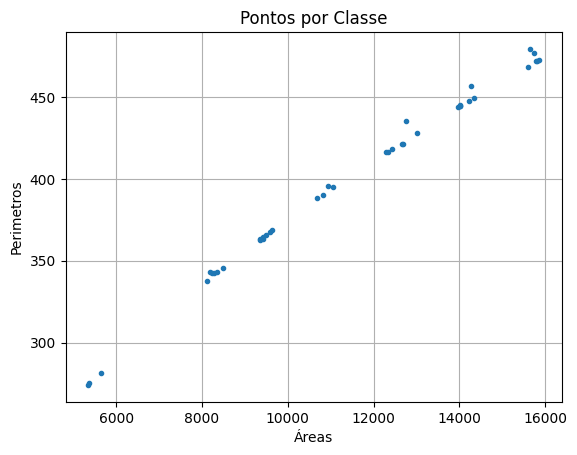

In [16]:
plt.plot(areas,pers,'.')
plt.title('Pontos por Classe')
plt.xlabel('Áreas')
plt.ylabel('Perimetros')
plt.grid()

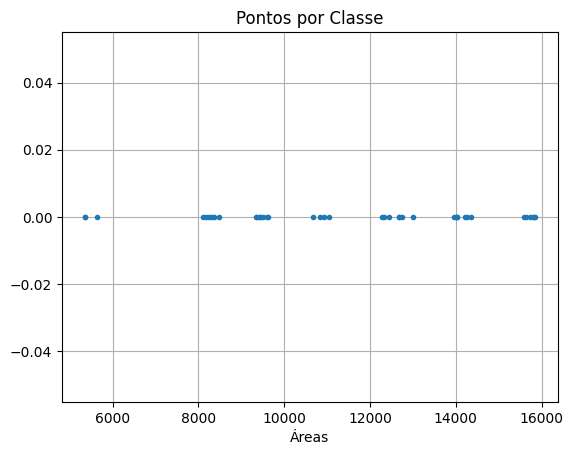

In [17]:
plt.plot(areas,np.zeros_like(areas),'.' )
plt.title('Pontos por Classe')
plt.xlabel('Áreas')
plt.grid()